# Build Deep Neural Network: Step by Step

In [1]:
import time
import numpy as np
import h5py
import scipy
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

### Parameters

In [2]:
# initialize parameters
def initialize_parameters(n_x, n_h, n_y):
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros(shape=(n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros(shape=(n_y, 1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1":W1, "b1":b1, "W2":W2, "b2":b2}
    return parameters

In [3]:
# test case
parameters = initialize_parameters(3,2,1)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 0.00212046  0.02672704 -0.00670835]
 [-0.00429206 -0.02338513  0.00468954]]
b1 = [[0.]
 [0.]]
W2 = [[ 0.00660583 -0.00368437]]
b2 = [[0.]]


In [4]:
# initialize parameters deep
def initialize_parameters_deep(layer_dims):
    parameters = {}
    l = len(layer_dims)
    
    for i in range(1,l):
        parameters['W' + str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1]) / np.sqrt(
        layer_dims[i-1])
        parameters['b' + str(i)] = np.zeros(shape=(layer_dims[i], 1))
    
        assert(parameters['W' + str(i)].shape == (layer_dims[i], layer_dims[i-1]))
        assert(parameters['b' + str(i)].shape == (layer_dims[i], 1))
    
    return parameters

In [5]:
# test case
parameters = initialize_parameters_deep([5,4,3])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 0.52517187 -0.41448655  0.11091291 -0.45016347  0.83998028]
 [-0.22097994  0.36116798 -0.28446236  0.03829356 -0.26131407]
 [-0.15831915  0.55381373 -0.36502711 -0.76552472 -0.27154572]
 [ 0.48890501  0.36912016  0.16662064 -0.30871639  0.00449452]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.11334698  0.13256051 -0.24348013 -0.34796225]
 [ 0.56527992 -0.09306361  0.24454679 -0.34677472]
 [-0.05005995 -0.04564713 -0.0227927  -0.08920081]]
b2 = [[0.]
 [0.]
 [0.]]


### Forward Propagation

In [6]:
# helper function
def sigmoid(Z):
    A = 1 / (1+np.exp(-Z))
    cache = Z
    return A, cache

def relu(Z):
    A = np.maximum(0,Z)
    cache = Z
    return A, cache

In [7]:
# linear forward
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    
    cache = (A, W, b)
    return Z, cache

In [8]:
# linear activation forward
def linear_activation_forward(A_prev, W, b, activation):
    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        A, activation_cache = relu(Z)
    
    assert(A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
    return A, cache

In [9]:
# L model forward
def L_model_forward(X, parameters):
    caches = []
    A = X
    l = len(parameters) // 2
    
    for i in range(1, l):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters["W{:d}".format(i)],
                                             parameters["b{:d}".format(i)], activation = "relu")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters["W"+str(l)], parameters["b"+str(l)], 
                                         activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1, X.shape[1]))
    return AL, caches

### Cost function

In [10]:
# compute cost
def compute_cost(AL, Y):
    m = Y.shape[1]
    
    cost = -1 / m * np.sum(Y*np.log(AL) + (1-Y)*np.log(1-AL))
    
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    return cost

### Backward Propagation

In [11]:
# helper function
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z<=0] = 0
    return dZ

def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/ (1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

In [12]:
#linear backward
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = 1 / m * np.dot(dZ, A_prev.T)
    db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    assert(dA_prev.shape == A_prev.shape)
    assert(dW.shape == W.shape)
    assert(db.shape == b.shape)
    
    return dA_prev, dW, db

In [13]:
# linear activation backward
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [14]:
# L model backward
def L_model_backward(AL, Y, caches):
    grads = {}
    l = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    dAL = - (np.divide(Y, AL) - np.divide(1-Y, 1-AL))
    current_cache = caches[l-1]
    
    grads["dA"+str(l-1)], grads["dW"+str(l)], grads["db"+str(l)] = linear_activation_backward(
        dAL, current_cache, activation = "sigmoid")
    
    for i in reversed(range(l-1)):
        current_cache = caches[i]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA"+str(i+1)], 
                                                                   current_cache, activation = "relu")
        grads["dA"+str(i)] = dA_prev_temp
        grads["dW"+str(i+1)] = dW_temp
        grads["db"+str(i+1)] = db_temp
    
    return grads

### Update parameters

In [15]:
# update parameters
def update_parameters(parameters, grads, learning_rate):
    l = len(parameters) // 2
    
    for i in range(l):
        parameters["W"+str(i+1)] = parameters["W" + str(i+1)] - learning_rate * grads["dW"+str(i+1)]
        parameters["b"+str(i+1)] = parameters["b" + str(i+1)] - learning_rate * grads["db"+str(i+1)]
    
    return parameters

# DNN for Image Classification
### Dataset

In [16]:
def load_dataset():
    train_dataset = h5py.File("/Users/jungyeonkoh/Desktop/catvnocat/train_catvnoncat.h5", "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    
    test_dataset = h5py.File("/Users/jungyeonkoh/Desktop/catvnocat/test_catvnoncat.h5", "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    classes = np.array(test_dataset["list_classes"][:])
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

y = 1. It's a cat picture.


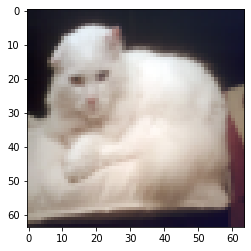

In [17]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_dataset()

# example of a picture
index = 13
plt.imshow(train_x_orig[index])
print("y = " + str(train_y[0, index]) + ". It's a " + classes[train_y[0, index]].decode("utf-8") + " picture.")

In [18]:
# explore your dataest
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print("Number of training examples: " + str(m_train))
print("Number of testing examples: " + str(m_test))
print("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("train_x_orig shape: " + str(train_x_orig.shape))
print("train_y_orig shape: " + str(train_y.shape))
print("test_x_orig shape: " + str(test_x_orig.shape))
print("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y_orig shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [19]:
# reshape the training and test examples
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# standardize data to have feature values between 0 and 1
train_x = train_x_flatten / 255.
test_x = test_x_flatten / 255.

print("train_x shape: " + str(train_x.shape))
print("test_x shape: " + str(test_x.shape))

train_x shape: (12288, 209)
test_x shape: (12288, 50)


### 2-layer neural network

In [20]:
n_x = 12288
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [21]:
# 2-layer model
def two_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False):
    grads = {}
    costs = []
    m = X.shape[1]
    (n_x, n_h, n_y) = layers_dims
    
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    for i in range(0, num_iterations):
        A1, cache1 = linear_activation_forward(X, W1, b1, activation="relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation="sigmoid")
        cost = compute_cost(A2, Y)
        
        dA2 = - (np.divide(Y, A2) - np.divide(1-Y, 1-A2))
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation="sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation="relu")
        grads["dW1"] = dW1
        grads["db1"] = db1
        grads["dW2"] = dW2
        grads["db2"] = db2
        
        parameters = update_parameters(parameters, grads, learning_rate)
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
    
    plt.plot(np.squeeze(costs))
    plt.ylabel("Cost")
    plt.xlabel("Iterations")
    plt.title("Learning Rate: " + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.6924834044357364
Cost after iteration 100: 0.6460913997730525
Cost after iteration 200: 0.6318524515148538
Cost after iteration 300: 0.6003598848702948
Cost after iteration 400: 0.5567865780951043
Cost after iteration 500: 0.5053096681162086
Cost after iteration 600: 0.44768635226541725
Cost after iteration 700: 0.3971863522858041
Cost after iteration 800: 0.36369104440890476
Cost after iteration 900: 0.35270553368847013
Cost after iteration 1000: 0.32046917193787744
Cost after iteration 1100: 0.27654915895757143
Cost after iteration 1200: 0.2989777623215756
Cost after iteration 1300: 0.25007537910469224
Cost after iteration 1400: 0.15976543856799116
Cost after iteration 1500: 0.2119870235060897
Cost after iteration 1600: 0.10583023817361972
Cost after iteration 1700: 0.09145187856992142
Cost after iteration 1800: 0.07875750903583273
Cost after iteration 1900: 0.06585290154895725
Cost after iteration 2000: 0.05739837098206394
Cost after iteration 2100: 0.04990

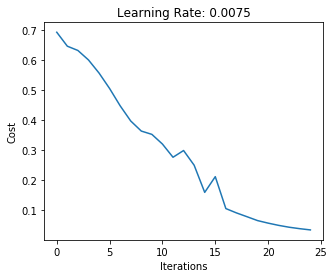

In [22]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, 
                            print_cost = True)

In [23]:
def predict(X, Y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2
    p = np.zeros((1, m))
    
    probas, caches = L_model_forward(X, parameters)
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    print("Accuracy: " + str(np.sum((p == Y) / m)))
    return p

In [24]:
predictions_train = predict(train_x, train_y, parameters)
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.9999999999999998
Accuracy: 0.7000000000000001


### L-layer neural network

In [25]:
layers_dims = [12288, 20, 7, 5, 1]

In [26]:
def L_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False):
    costs = []
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
    
    plt.plot(np.squeeze(costs))
    plt.ylabel("Cost")
    plt.xlabel("Iterations")
    plt.title("Learning Rate: " + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.6959936507822072
Cost after iteration 100: 0.62941724309701
Cost after iteration 200: 0.6015649653902285
Cost after iteration 300: 0.5663374752493893
Cost after iteration 400: 0.5261355089238294
Cost after iteration 500: 0.47659997706927215
Cost after iteration 600: 0.4194506706849119
Cost after iteration 700: 0.38370573239727823
Cost after iteration 800: 0.3575795811783809
Cost after iteration 900: 0.3521950170823434
Cost after iteration 1000: 0.3327320607041244
Cost after iteration 1100: 0.21094996384574477
Cost after iteration 1200: 0.22405514117197797
Cost after iteration 1300: 0.11801904458767082
Cost after iteration 1400: 0.0925835338229037
Cost after iteration 1500: 0.06496541913454144
Cost after iteration 1600: 0.048516077198731834
Cost after iteration 1700: 0.037619725807042655
Cost after iteration 1800: 0.03000306691429192
Cost after iteration 1900: 0.02451630670321471
Cost after iteration 2000: 0.020426293881302033
Cost after iteration 2100: 0.01728

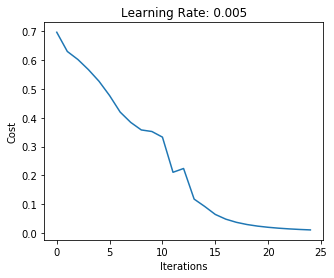

In [27]:
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.005, num_iterations = 2500, print_cost = True)

In [28]:
prediction_train = predict(train_x, train_y, parameters)
prediction_test = predict(test_x, test_y, parameters)

Accuracy: 0.9999999999999998
Accuracy: 0.74


In [29]:
def print_mislabeled_images(classes, X, Y, p):
    a = p + Y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams["figure.figsize"] = (40.0, 40.0)
    num_images = len(mislabeled_indices[0])
    
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        plt.subplot(2, num_images, i+1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation = "nearest")
        plt.axis("off")
        plt.title("Prediction: " + classes[int(p[0, index])].decode("utf-8"))

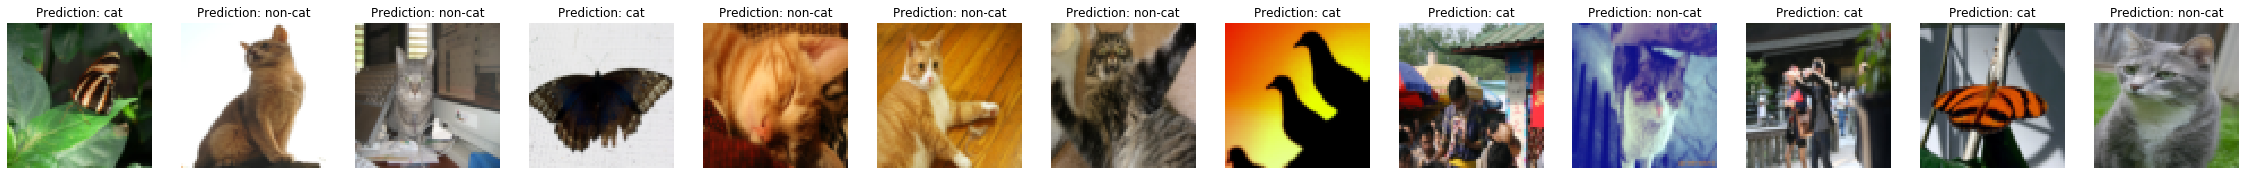

In [30]:
print_mislabeled_images(classes, test_x, test_y, prediction_test)